# COVID-19 Data Analysis
- Data is provided Johns Hopkins University <a href='https://github.com/CSSEGISandData/COVID-19'>here</a>

In [0]:
# Import libraries
import shutil
import os
import stat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tensorflow import keras
import tensorflow as tf
import numpy as np
import folium
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime, timedelta

%matplotlib inline

In [0]:
# Declare important variables
raw_data_path = 'raw_data/'
confirmed_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [0]:
# Run this cell to get latest data
# def handle_remove_readonly(func, path, exc):
#     if not os.access(path, os.W_OK):
#         os.chmod(path, stat.S_IWUSR)
#         func(path)
#     else:
#         raise
        
# if(os.path.exists(raw_data_path)):
#     shutil.rmtree(raw_data_path, onerror=handle_remove_readonly)
    
# !git clone https://github.com/CSSEGISandData/COVID-19.git $raw_data_path

## Data Analysis
### Worldwide cases analytic

In [0]:
# Declare dataframe
df_confirmed = pd.read_csv(confirmed_data_path)
df_death = pd.read_csv(death_data_path)
df_recovered = pd.read_csv(recovered_data_path)

In [38]:
# Covid cases distribution
map_view = folium.Map(location=[10,0], zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001))))*20000,
        color='#ffaf7a',
        fill_color='#ffaf7a').add_to(map_view)

map_view

In [0]:
dates = df_confirmed.columns[4:].tolist()

Text(0.5, 0, 'Number of confirmed cases (updated: 5/14/20)')

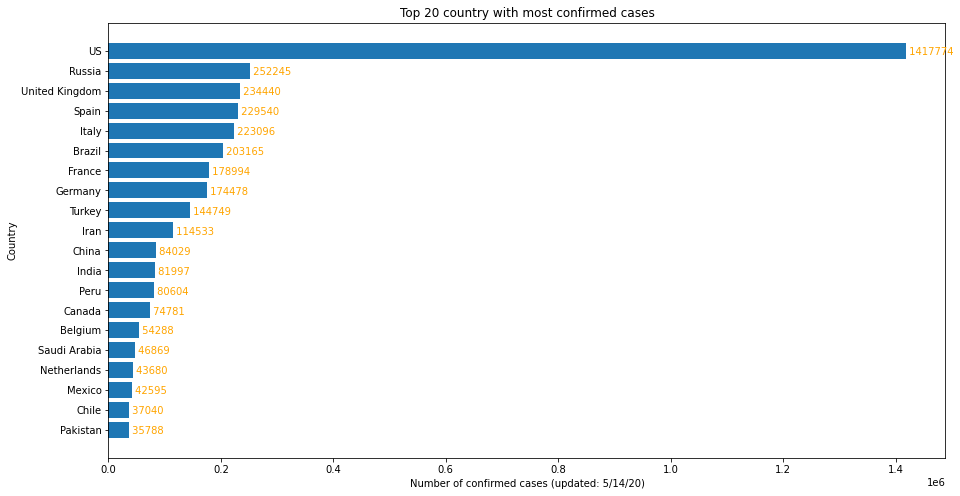

In [40]:
# Sum the amount of cases in different state group by country
df_confirmed_country = df_confirmed.groupby('Country/Region')[dates].sum().reset_index()
df_confirmed_country = df_confirmed_country.sort_values(by=df_confirmed_country.columns[-1], ascending=False)

# Plot the chart for top 20 most confirmed cases
plt.figure(figsize=(15,8))
plt.barh(df_confirmed_country[df_confirmed_country.columns[0]].iloc[:20][::-1], 
         df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='orange')
plt.title('Top 20 country with most confirmed cases')
plt.ylabel('Country')
plt.xlabel(f'Number of confirmed cases (updated: {df_confirmed_country.columns[-1]})')

Text(0.5, 0, 'Number of death cases (updated: 5/14/20)')

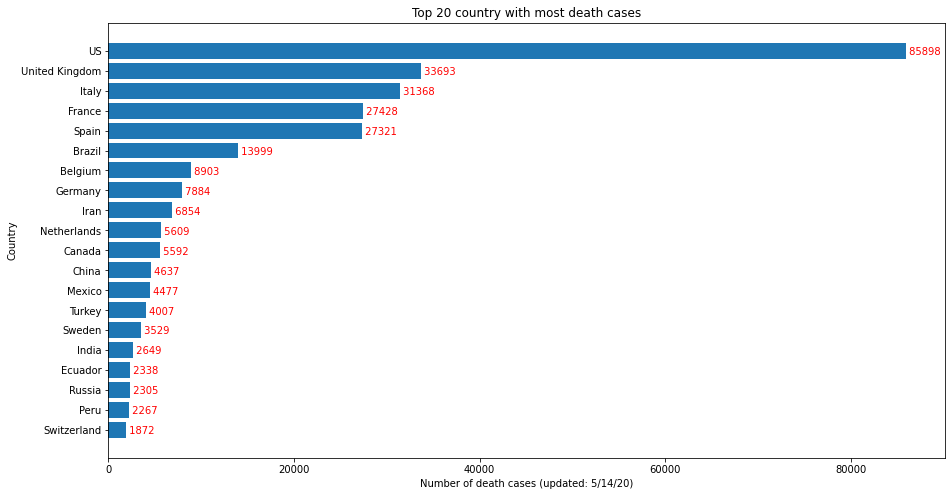

In [41]:
# Sum the amount of cases in different state group by country
df_death_country = df_death.groupby('Country/Region')[dates].sum().reset_index()
df_death_country = df_death_country.sort_values(by=df_death_country.columns[-1], ascending=False)

# Plot the chart for top 20 most death cases
plt.figure(figsize=(15,8))
plt.barh(df_death_country[df_death_country.columns[0]].iloc[:20][::-1], 
         df_death_country[df_death_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_death_country[df_death_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='red')
plt.title('Top 20 country with most death cases')
plt.ylabel('Country')
plt.xlabel(f'Number of death cases (updated: {df_death_country.columns[-1]})')

Text(0.5, 0, 'Number of recovered cases (updated: 5/14/20)')

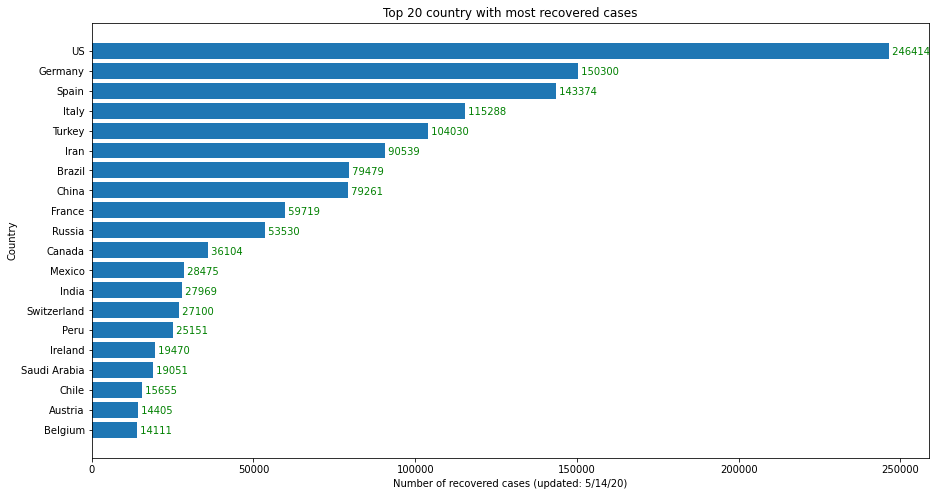

In [42]:
# Sum the amount of cases in different state group by country
df_recovered_country = df_recovered.groupby('Country/Region')[dates].sum().reset_index()
df_recovered_country = df_recovered_country.sort_values(by=df_recovered_country.columns[-1], ascending=False)

# Plot the chart for top 20 most recovered cases
plt.figure(figsize=(15,8))
plt.barh(df_recovered_country[df_recovered_country.columns[0]].iloc[:20][::-1], 
         df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='green')
plt.title('Top 20 country with most recovered cases')
plt.ylabel('Country')
plt.xlabel(f'Number of recovered cases (updated: {df_recovered_country.columns[-1]})')

In [43]:
# Aggregate the latest number for confirmed, death and recovered cases for each country
df_agg = df_confirmed_country.iloc[:,[0,-1]].rename(columns={'Country/Region':'country',dates[-1]:'confirmed'})
df_agg = df_agg.join(df_death_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'death'})
df_agg = df_agg.join(df_recovered_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'recovered'})
df_agg.head(2)

,country,confirmed,death,recovered
174,US,1417774,85898,246414
140,Russia,252245,2305,53530


In [44]:
# Calculate the current active cases and rate of death and recovered
df_agg['current_active'] = df_agg['confirmed'] - df_agg['death'] - df_agg['recovered']
df_agg['death_rate'] = round((df_agg['death'] / df_agg['confirmed']) * 100, 2)
df_agg['recovered_rate'] = round((df_agg['recovered'] / df_agg['confirmed']) * 100, 2)
df_agg.head(2)

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,1417774,85898,246414,1085462,6.06,17.38
140,Russia,252245,2305,53530,196410,0.91,21.22


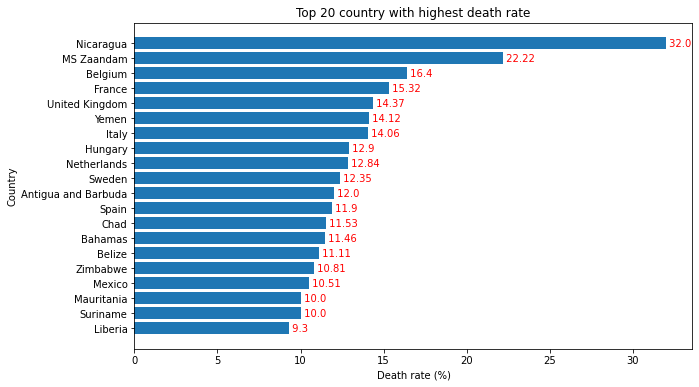

In [45]:
df_agg.sort_values(by='death_rate', inplace=True)

# Plot top 20 highest death rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['death_rate'].iloc[-20:])
plt.title("Top 20 country with highest death rate")
plt.xlabel("Death rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['death_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='red')

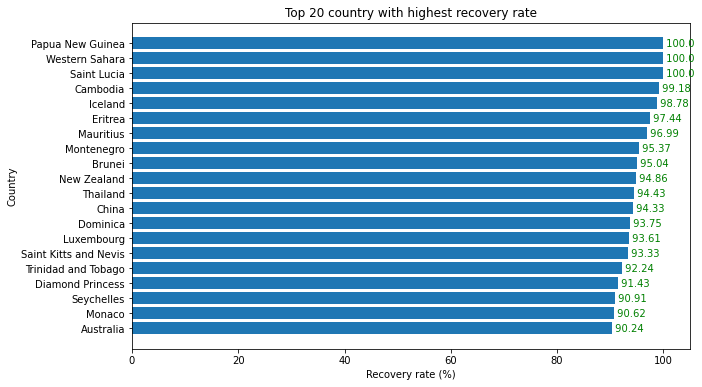

In [46]:
df_agg.sort_values(by='recovered_rate', inplace=True)

# Plot top 20 highest recovery rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['recovered_rate'].iloc[-20:])
plt.title("Top 20 country with highest recovery rate")
plt.xlabel("Recovery rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['recovered_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='green')

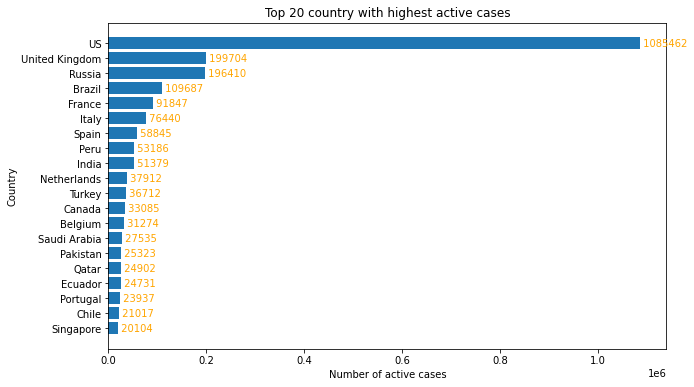

In [47]:
df_agg.sort_values(by='current_active', inplace=True)

# Plot top 20 highest active case
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['current_active'].iloc[-20:])
plt.title("Top 20 country with highest active cases")
plt.xlabel("Number of active cases")
plt.ylabel("Country")

for i, v in enumerate(df_agg['current_active'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='orange')

In [48]:
df_agg.sort_values(by='current_active', ascending=False, inplace=True)
df_agg.style.background_gradient(cmap='Reds')

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,1417774,85898,246414,1085462,6.060000,17.380000
178,United Kingdom,234440,33693,1043,199704,14.370000,0.440000
140,Russia,252245,2305,53530,196410,0.910000,21.220000
23,Brazil,203165,13999,79479,109687,6.890000,39.120000
62,France,178994,27428,59719,91847,15.320000,33.360000
85,Italy,223096,31368,115288,76440,14.060000,51.680000
158,Spain,229540,27321,143374,58845,11.900000,62.460000
134,Peru,80604,2267,25151,53186,2.810000,31.200000
79,India,81997,2649,27969,51379,3.230000,34.110000
122,Netherlands,43680,5609,159,37912,12.840000,0.360000


### Malaysia Cases Analytic

In [0]:
# Extract Malaysia time series data
my_confirmed = df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_recovered = df_recovered[df_recovered['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_death = df_death[df_death['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_active = my_confirmed - my_recovered - my_death

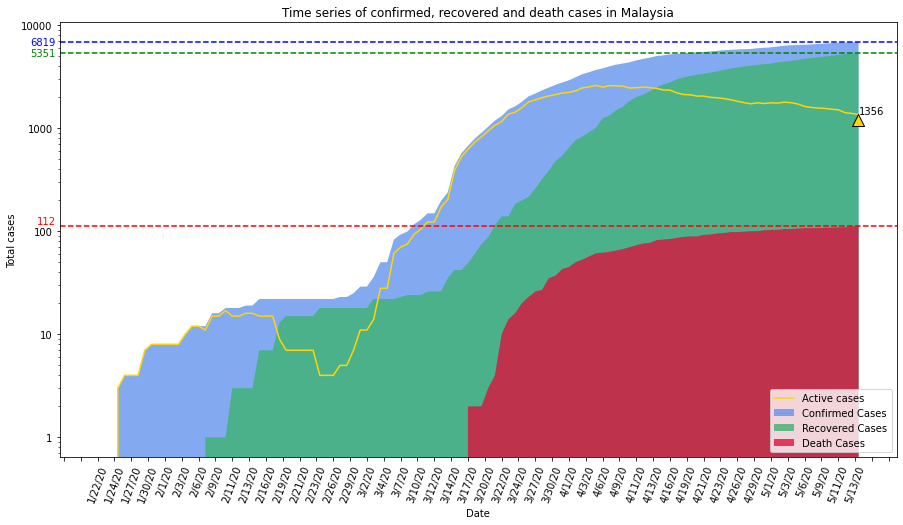

In [50]:
# Plot chart of cases in Malaysia
plt.figure(figsize=(15,8))

plt.fill_between(dates, my_confirmed, facecolor='cornflowerBlue', alpha=0.8, label='Confirmed Cases')
plt.fill_between(dates, my_recovered, facecolor='mediumSeaGreen', alpha=0.8, label='Recovered Cases')
plt.fill_between(dates, my_death, facecolor='crimson', alpha=0.8, label='Death Cases')
plt.plot(dates, my_active, color='gold', label='Active cases')

plt.axhline(y=my_confirmed[-1], color='blue', linestyle='--')
plt.axhline(y=my_recovered[-1], color='green', linestyle='--')
plt.axhline(y=my_death[-1], color='red', linestyle='--')
plt.text(-10, my_confirmed[-1], my_confirmed[-1], color='blue', va='center')
plt.text(-10, my_recovered[-1], my_recovered[-1], color='green', va='center')
plt.text(-9, my_death[-1] + 5, my_death[-1], color='red')
plt.annotate(s=my_active[-1], xy=(dates[-1], my_active[-1]), arrowprops=dict(facecolor='gold', shrink=0.05))

plt.yscale('log')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xticks(rotation=70)
plt.title('Time series of confirmed, recovered and death cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('Total cases')
plt.legend()

#### Predictive Model for Malaysia cases

In [0]:
# previous sequences used in LSTM
prev_day = 14

In [52]:
# Run this cell for training on colab TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.101.161.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.101.161.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [71]:
keras.backend.clear_session()

in_data = keras.Input((prev_day,3),dtype='float32')

X = keras.layers.LSTM(units=512,return_sequences=True)(in_data)
X = keras.layers.Dropout(0.2)(X)
X = keras.layers.LSTM(units=256,return_sequences=True)(X)
X = keras.layers.Dropout(0.2)(X)
X = keras.layers.LSTM(units=128)(X)
# X = keras.layers.Dropout(0.2)(X)
X = keras.layers.Dense(64, activation='relu')(X)
X = keras.layers.Dense(32, activation='relu')(X)
X = keras.layers.Dense(3, activation='relu')(X)

# Create Model instance which converts sentence_indices into X.
model = keras.models.Model(inputs=in_data, outputs=X)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 14, 512)           1056768   
_________________________________________________________________
dropout (Dropout)            (None, 14, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 64)                8256  

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
# Create training input for lstm

sample_confirmed = np.pad(my_confirmed, (prev_day,0), 'constant', constant_values=0).reshape(my_confirmed.shape[0]+prev_day, 1)
sample_confirmed = [sample_confirmed[i:i+prev_day]for i in range(0, len(sample_confirmed)-prev_day,1)]
sample_confirmed = np.array(sample_confirmed).reshape(len(sample_confirmed),prev_day,1).astype(float)
sample_recovered = np.pad(my_recovered, (prev_day,0), 'constant', constant_values=0).reshape(my_recovered.shape[0]+prev_day, 1)
sample_recovered = [sample_recovered[i:i+prev_day]for i in range(0, len(sample_recovered)-prev_day,1)]
sample_recovered = np.array(sample_recovered).reshape(len(sample_recovered),prev_day,1).astype(float)
sample_death = np.pad(my_death, (prev_day,0), 'constant', constant_values=0).reshape(my_death.shape[0]+prev_day, 1)
sample_death = [sample_death[i:i+prev_day]for i in range(0, len(sample_death)-prev_day,1)]
sample_death = np.array(sample_death).reshape(len(sample_death),prev_day,1).astype(float)

features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=2)

label_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
label_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
label_death = np.array(my_death).reshape(len(my_death),1).astype(float)

label = np.concatenate((label_confirmed, label_recovered, label_death), axis=1)

# X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = features
y_train = label
X_train, y_train = shuffle(X_train, y_train)
print(X_train.shape, y_train.shape)

(114, 14, 3) (114, 3)


Epoch 1/3000
1/1 [==============================] - 1s 973ms/step - loss: 5706764.0000 - val_loss: 5044041.5000
Epoch 2/3000
1/1 [==============================] - 0s 55ms/step - loss: 5706420.5000 - val_loss: 5043339.5000
Epoch 3/3000
1/1 [==============================] - 0s 53ms/step - loss: 5705622.5000 - val_loss: 5042571.5000
Epoch 4/3000
1/1 [==============================] - 0s 55ms/step - loss: 5704724.0000 - val_loss: 5041837.5000
Epoch 5/3000
1/1 [==============================] - 0s 56ms/step - loss: 5703845.5000 - val_loss: 5041115.0000
Epoch 6/3000
1/1 [==============================] - 0s 55ms/step - loss: 5702975.5000 - val_loss: 5040353.0000
Epoch 7/3000
1/1 [==============================] - 0s 52ms/step - loss: 5702070.0000 - val_loss: 5039598.5000
Epoch 8/3000
1/1 [==============================] - 0s 54ms/step - loss: 5701161.0000 - val_loss: 5038841.5000
Epoch 9/3000
1/1 [==============================] - 0s 58ms/step - loss: 5700248.0000 - val_loss: 5038061.0000


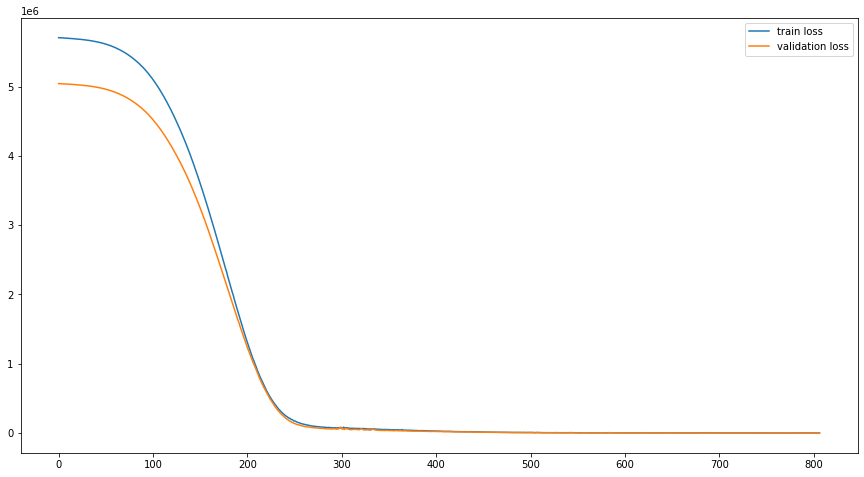

In [74]:
history = model.fit(x=X_train, y=y_train, 
                    epochs=3000, 
                    batch_size=X_train.shape[0], 
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[keras.callbacks.EarlyStopping(patience=50)])

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [0]:
# Forecasting day
forecast_days = 7

pred_feature = features[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], y_pred[-1].reshape((1,1,3))),axis=1)
pred_date = dates

for day in range(forecast_days):
    pred = model.predict(pred_feature)
    y_pred = np.concatenate((y_pred, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,3))),axis=1) 
    

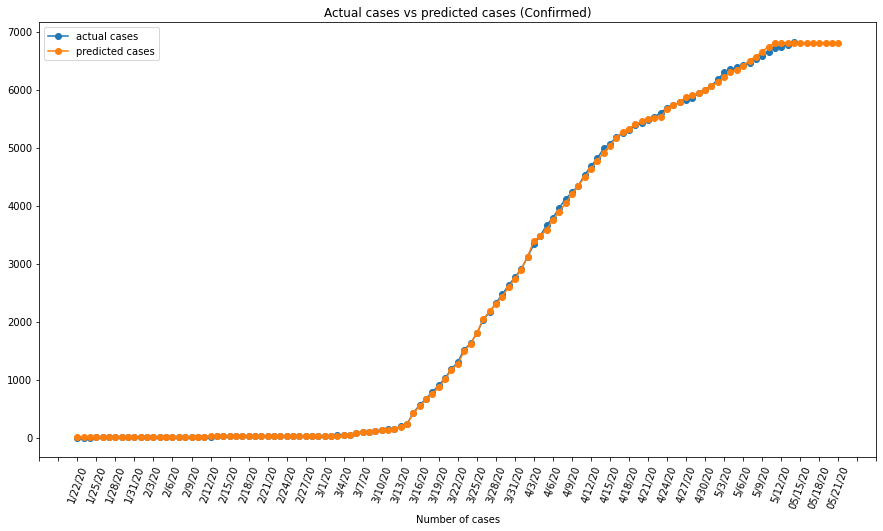

In [77]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_confirmed, marker='o', label='actual cases')
plt.plot(pred_date, y_pred[:,0], marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Confirmed)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

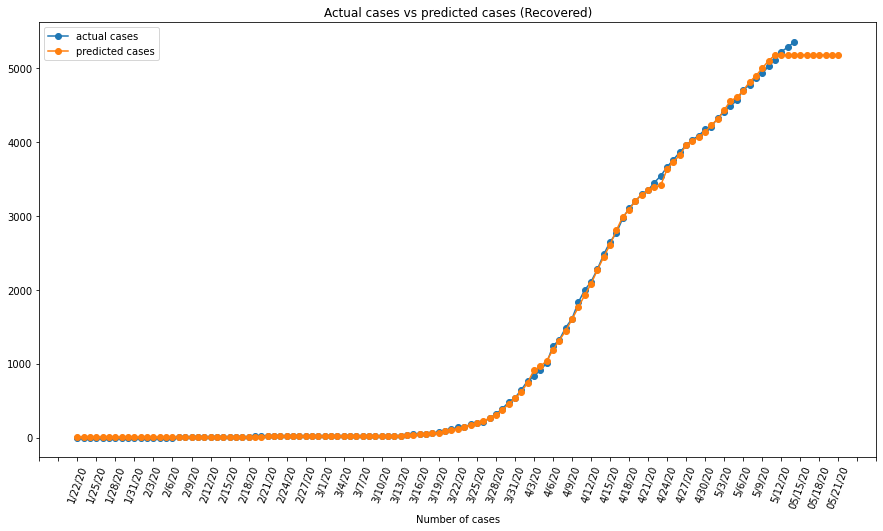

In [78]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_recovered, marker='o', label='actual cases')
plt.plot(pred_date, y_pred[:,1], marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Recovered)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

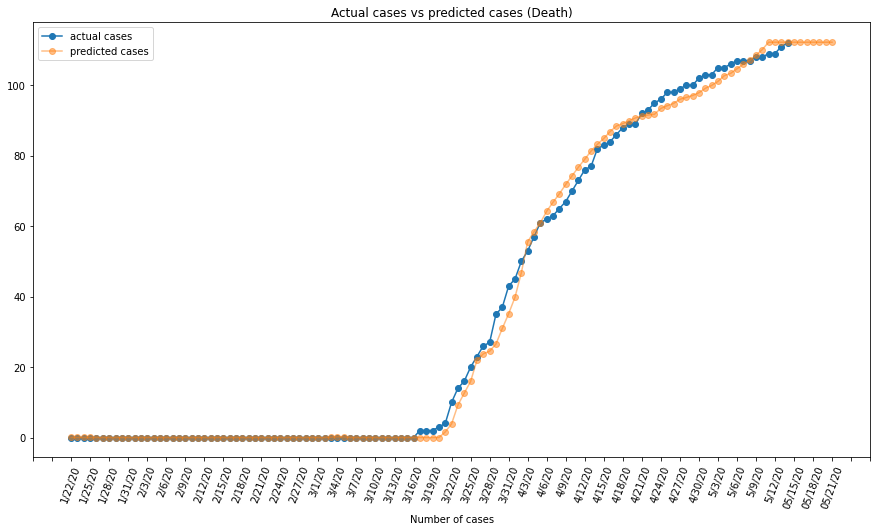

In [80]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_death, marker='o', label='actual cases')
plt.plot(pred_date, y_pred[:,2], marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Death)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()